In [27]:
from linearmodels.panel import PooledOLS, PanelOLS

import statsmodels.api as sm
import numpy as np
import pandas as pd
import plotly.express as px
from plotly.subplots import make_subplots
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
import statsmodels.formula.api as smf

from statsmodels.iolib.summary2 import summary_col

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
from urllib.request import urlopen
import json
import plotly
with urlopen('https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json') as response:
    counties = json.load(response)

In [58]:
def plotByState(dataset, valueColName, colorbarLabel, saveFilePath, stateColName = 'state_code'):
    #Extract only state data

    valueRange = (min(dataset[valueColName]), max(dataset[valueColName]))

    fig = px.choropleth(dataset, locations=dataset[stateColName], locationmode="USA-states",
    color=valueColName,color_continuous_scale="Viridis",
    range_color=valueRange,scope="usa",labels={valueColName:colorbarLabel},
    hover_name=stateColName)
    
    fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
    fig.write_html(saveFilePath, auto_open=True)
    
def scatterplotLinear(x,y, xlabel, ylabel):
    plt.plot(x,y,'o')
    m,b = np.polyfit(x,y,1)
    plt.plot(x, m*x + b)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

## Read in data

In [4]:
us_daily = pd.read_csv("data/cleaned/daily_df.csv", index_col=0)
us_daily["date"] = pd.to_datetime(us_daily["date"])
us_daily = us_daily.set_index("date")

In [5]:
us_monthly = us_daily.groupby([pd.Grouper(freq='M'), 'state']).mean()
us_monthly
us_monthly = pd.DataFrame(us_monthly.to_records())

In [6]:
micperceptions = pd.read_csv("data/cleaned/misperception_state_inferred.csv", index_col=0)
micperceptions = pd.DataFrame(micperceptions.to_records())
micperceptions.columns = ["state", "pc_misperception"]
micperceptions.pc_misperception = micperceptions.pc_misperception.str.rstrip('%').astype('float') / 100.0

In [7]:
us_cross_sectional = us_daily.loc[(us_daily.index >= "2020-03-01") & (us_daily.index <= "2021-01-31")].groupby(["state"]).mean()
us_Aug = us_daily.loc[(us_daily.index >= "2020-08-01") & (us_daily.index <= "2021-08-31")].groupby(["state"]).mean()

In [8]:
us_cross_sectional = pd.merge(us_cross_sectional, micperceptions, on="state")
us_Aug = pd.merge(us_Aug, micperceptions, on="state")

In [9]:
reported_compliance = pd.read_csv("data/covidstates/beh_2.csv", index_col=0)

US_state_abb = pd.read_csv("data/US_state_abb.csv")
US_state_abb.columns = ["state", "state_abb"]
reported_compliance = pd.merge(reported_compliance, US_state_abb, on="state_abb", how="left")

In [10]:
reported_compliance.columns = ["state_abb", "not_at_all", "not_very", "somewhat", "very", "error_margin", "N", "wave", "state"]

In [11]:
news_source = pd.read_csv("data/news_source.csv", index_col=0)
news_source = news_source.rename({'state': 'state_abb'}, axis=1)

source_false_prop = pd.read_csv("data/Source_false_prop.csv", index_col=0)

news_source = pd.merge(news_source, US_state_abb, on="state_abb", how="left")

In [12]:
news_source["misinformation_index"] = 0

In [13]:
source_false_prop

,Friends and family,Radio news,Podcasts,Local television,"Network television (e.g. ABC, CBS, or NBC)","Cable television (e.g. CNN, Fox News, or MSNBC)",Late-night comedy shows (e.g. The Late Show with Stephen Colbert or The Daily Show),Print newspapers (e.g. the New York Times or the Wall Street Journal print edition),A news website or app (e.g. the New York Times or Fox News websites or apps),A health website or app (e.g. WebMD),...,Snapchat (website or app),Wikipedia (website or app),Error Margin.1,N.1,CNN,Fox News,MSNBC,President Trump’s press briefings,Error Margin.2,N.2
source,,,,,,,,,,,,,,,,,,,,,
false_percentage,0.13,0.14,0.18,0.11,0.12,0.12,0.16,0.12,0.11,0.17,...,0.26,0.25,NaN,NaN,0.16,0.18,0.15,0.18,NaN,NaN


In [14]:
sources = [
    "Friends and family",
    "Radio news",
    "Podcasts",
    "Local television",
    "Network television (e.g.  ABC, CBS, or NBC)",
    "Late-night comedy shows (e.g. The Late Show with Stephen Colbert or The Daily Show)",
    "Print newspapers (e.g. the New York Times or the Wall Street Journal print edition)",
    "A news website or app (e.g. the New York Times or Fox News websites or apps)",
    "A health website or app (e.g. WebMD)",
    "A government website or app (e.g. CDC.gov)",
    "An organization website or app (e.g. WHO.int)",
    "A search engine website or app (e.g. Google, Bing)",
    "Facebook (website or app)",
    "Twitter (website or app)",
    "Youtube(website or app)",
    "Reddit (website or app)",
    "Instagram (website or app)",
    "Snapchat  (website or app)",
    "Wikipedia (website or app)",
    "CNN",
    "Fox News",
    "MSNBC",
    "President Trump’s press briefings",
]

In [15]:
source = "Friends and family"

In [16]:
index = news_source["misinformation_index"]
for source in sources:
    index = index + news_source[source] * float(source_false_prop[source])
news_source["misinformation_index"] = index
news_misperception = news_source[["state", "wave", "misinformation_index"]]


In [17]:
reported_compliance_cross_sectional = reported_compliance.groupby(["state"]).mean().drop("wave", axis = 1)
news_misperception_cross_sectional = news_misperception.groupby(["state"]).mean().drop("wave", axis = 1)

us_cross_sectional = pd.merge(us_cross_sectional, reported_compliance_cross_sectional, on="state", how="left")
us_cross_sectional = pd.merge(us_cross_sectional, news_misperception_cross_sectional, on="state", how="left")

reported_compliance_Aug = reported_compliance.loc[reported_compliance["wave"] == 9].groupby(["state"]).mean()
news_misperception_Aug = news_misperception.loc[news_misperception["wave"] == 9].groupby(["state"]).mean().drop("wave", axis = 1)

In [18]:
us_Aug = pd.merge(us_Aug, reported_compliance_Aug, on="state", how="left")
us_Aug = pd.merge(us_Aug, news_misperception_Aug, on="state", how="left")

In [19]:
reported_compliance_Aug.columns

Index(['not_at_all', 'not_very', 'somewhat', 'very', 'error_margin', 'N',
       'wave'],
      dtype='object')

## Disease outcomes

In [20]:
us_cross_sectional["deaths_pth"] = 1000 * us_cross_sectional["deathIncrease"] / us_cross_sectional["pop_2019"]
us_Aug["deaths_pth"] = 1000 * us_Aug["deathIncrease"] / us_Aug["pop_2019"]

In [21]:
us_cross_sectional["hospitalized_pth"] = 1000 * us_cross_sectional["hospitalizedIncrease"] / us_cross_sectional["pop_2019"]
us_Aug["hospitalized_pth"] = 1000 * us_Aug["hospitalizedIncrease"] / us_Aug["pop_2019"]

In [22]:
us_cross_sectional["positivity_rate"] = us_cross_sectional["positiveIncrease"] / us_cross_sectional["totalTestResultsIncrease"]
us_Aug["positivity_rate"] = us_Aug["positiveIncrease"] / us_Aug["totalTestResultsIncrease"]

In [54]:
#US State map of misperception and misinformation cross sectional data
with open('data/google_mobility/EDA_and_Viz/states_hash.json', 'r+') as file:
    states_hash = json.load(file)
states_hash = { v:k for (k,v) in states_hash.items()}
us_cross_sectional['state_code'] = us_cross_sectional['state'].map(states_hash)

plotByState(us_cross_sectional, 'pc_misperception', colorbarLabel = 'Misconception %', saveFilePath = 'data/models/state_xsectional_misconception.html')
plotByState(us_cross_sectional, 'misinformation_index', colorbarLabel = 'Misinformation Index', saveFilePath = 'data/models/state_xsectional_misinformation.html')

In [65]:
#Maps of covid metrics
# for col in us_cross_sectional.columns: 
#     print(col) 

plotByState(us_cross_sectional, 'deaths_pth', 'Deaths per thousand', 'data/models/state_xsectional_death_pth.html')
plotByState(us_cross_sectional, 'hospitalized_pth', 'Hospitalized per thousand', 'data/models/state_xsectional_hosp_pth.html')
plotByState(us_cross_sectional, 'positivity_rate', 'Positive COVID test rate', 'data/models/state_xsectional_posRate.html')

There is a generally positive relationship between the level of misperceptions and severity of disease outcomes. 

In [21]:
cross_sectional_reg_1_posrate = smf.ols('positivity_rate ~ pc_misperception', data=us_cross_sectional).fit()
cross_sectional_reg_1_posrate.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        positivity_rate   R-squared:                       0.085
Model:                            OLS   Adj. R-squared:                  0.066
Method:                 Least Squares   F-statistic:                     4.453
Date:                Sun, 21 Feb 2021   Prob (F-statistic):             0.0401
Time:                        10:41:45   Log-Likelihood:                 73.832
No. Observations:                  50   AIC:                            -143.7
Df Residuals:                      48   BIC:                            -139.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -0.0239      0.058     -0.411      0.683      -0.141       0.093
pc_misperception     0.8763      0.415      2.110      0.040       0.041       1.711
==============================================================================
Omnibus:                       26.837   Durbin-Watson:                   1.835
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               45.997
Skew:                           1.716   Prob(JB):                     1.03e-10
Kurtosis:                       6.208   Cond. No.                         53.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

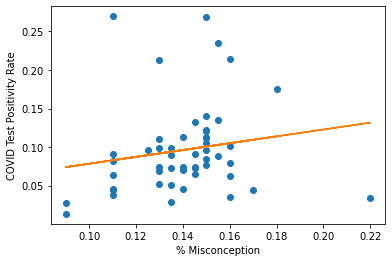

In [60]:
scatterplotLinear(us_cross_sectional['pc_misperception'], us_cross_sectional['positivity_rate'], '% Misconception', 'COVID Test Positivity Rate')

In [22]:
cross_sectional_reg_1_dea = smf.ols('deaths_pth ~ pc_misperception', data=us_cross_sectional).fit()
cross_sectional_reg_1_dea.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             deaths_pth   R-squared:                       0.085
Model:                            OLS   Adj. R-squared:                  0.066
Method:                 Least Squares   F-statistic:                     4.462
Date:                Sun, 21 Feb 2021   Prob (F-statistic):             0.0399
Time:                        10:41:45   Log-Likelihood:                 254.97
No. Observations:                  50   AIC:                            -505.9
Df Residuals:                      48   BIC:                            -502.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.0005      0.002      0.339      0.736      -0.003       0.004
pc_misperception     0.0234      0.011      2.112      0.040       0.001       0.046
==============================================================================
Omnibus:                        0.662   Durbin-Watson:                   1.949
Prob(Omnibus):                  0.718   Jarque-Bera (JB):                0.754
Skew:                           0.242   Prob(JB):                        0.686
Kurtosis:                       2.643   Cond. No.                         53.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

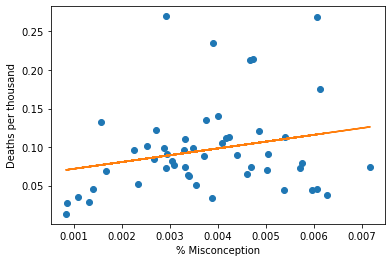

In [62]:
scatterplotLinear(us_cross_sectional['deaths_pth'], us_cross_sectional['positivity_rate'], '% Misconception', 'Deaths per thousand')

In [23]:
Aug_reg_1_posrate = smf.ols("positivity_rate ~ pc_misperception", data=us_Aug).fit()
Aug_reg_1_posrate.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        positivity_rate   R-squared:                       0.058
Model:                            OLS   Adj. R-squared:                  0.039
Method:                 Least Squares   F-statistic:                     2.979
Date:                Sun, 21 Feb 2021   Prob (F-statistic):             0.0908
Time:                        10:41:45   Log-Likelihood:                 61.110
No. Observations:                  50   AIC:                            -118.2
Df Residuals:                      48   BIC:                            -114.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -0.0219      0.075     -0.292      0.771      -0.173       0.129
pc_misperception     0.9243      0.536      1.726      0.091      -0.153       2.001
==============================================================================
Omnibus:                       30.797   Durbin-Watson:                   1.783
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               58.436
Skew:                           1.932   Prob(JB):                     2.05e-13
Kurtosis:                       6.621   Cond. No.                         53.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [24]:
Aug_reg_1_posrate = smf.ols('positivity_rate ~ pc_misperception', data=us_Aug).fit()
Aug_reg_1_posrate.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        positivity_rate   R-squared:                       0.058
Model:                            OLS   Adj. R-squared:                  0.039
Method:                 Least Squares   F-statistic:                     2.979
Date:                Sun, 21 Feb 2021   Prob (F-statistic):             0.0908
Time:                        10:41:45   Log-Likelihood:                 61.110
No. Observations:                  50   AIC:                            -118.2
Df Residuals:                      48   BIC:                            -114.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -0.0219      0.075     -0.292      0.771      -0.173       0.129
pc_misperception     0.9243      0.536      1.726      0.091      -0.153       2.001
==============================================================================
Omnibus:                       30.797   Durbin-Watson:                   1.783
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               58.436
Skew:                           1.932   Prob(JB):                     2.05e-13
Kurtosis:                       6.621   Cond. No.                         53.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [25]:
Aug_reg_1_dea = smf.ols('deaths_pth ~ pc_misperception', data=us_Aug).fit()
Aug_reg_1_dea.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             deaths_pth   R-squared:                       0.160
Model:                            OLS   Adj. R-squared:                  0.143
Method:                 Least Squares   F-statistic:                     9.159
Date:                Sun, 21 Feb 2021   Prob (F-statistic):            0.00397
Time:                        10:41:45   Log-Likelihood:                 244.14
No. Observations:                  50   AIC:                            -484.3
Df Residuals:                      48   BIC:                            -480.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -0.0007      0.002     -0.377      0.708      -0.005       0.003
pc_misperception     0.0417      0.014      3.026      0.004       0.014       0.069
==============================================================================
Omnibus:                        0.554   Durbin-Watson:                   1.759
Prob(Omnibus):                  0.758   Jarque-Bera (JB):                0.662
Skew:                          -0.082   Prob(JB):                        0.718
Kurtosis:                       2.460   Cond. No.                         53.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [26]:
print(summary_col([cross_sectional_reg_1_posrate, cross_sectional_reg_1_dea, Aug_reg_1_posrate, Aug_reg_1_dea],stars=True, float_format="%0.3f").as_latex())

\begin{table}
\caption{}
\label{}
\begin{center}
\begin{tabular}{lllll}
\hline
                  & positivity\_rate I & deaths\_pth I & positivity\_rate II & deaths\_pth II  \\
\hline
Intercept         & -0.024             & 0.001         & -0.022              & -0.001          \\
                  & (0.058)            & (0.002)       & (0.075)             & (0.002)         \\
pc\_misperception & 0.876**            & 0.023**       & 0.924*              & 0.042***        \\
                  & (0.415)            & (0.011)       & (0.536)             & (0.014)         \\
R-squared         & 0.085              & 0.085         & 0.058               & 0.160           \\
R-squared Adj.    & 0.066              & 0.066         & 0.039               & 0.143           \\
\hline
\end{tabular}
\end{center}
\end{table}


In [27]:
cross_sectional_reg_3_posrate = smf.ols('positivity_rate ~ pc_misperception + misinformation_index + White + Urbanization_rate', data=us_cross_sectional).fit()
cross_sectional_reg_3_posrate.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        positivity_rate   R-squared:                       0.158
Model:                            OLS   Adj. R-squared:                  0.084
Method:                 Least Squares   F-statistic:                     2.118
Date:                Sun, 21 Feb 2021   Prob (F-statistic):             0.0942
Time:                        10:41:46   Log-Likelihood:                 75.926
No. Observations:                  50   AIC:                            -141.9
Df Residuals:                      45   BIC:                            -132.3
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                0.1768      0.196      0.900      0.373      -0.219       0.572
pc_misperception         1.1730      0.468      2.508      0.016       0.231       2.115
misinformation_index    -0.0046      0.003     -1.383      0.173      -0.011       0.002
White                    0.0165      0.082      0.201      0.842      -0.149       0.182
Urbanization_rate     6.173e-05      0.001      0.089      0.930      -0.001       0.001
==============================================================================
Omnibus:                       21.595   Durbin-Watson:                   1.974
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               31.075
Skew:                           1.474   Prob(JB):                     1.79e-07
Kurtosis:                       5.496   Cond. No.                     5.54e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.54e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [28]:
cross_sectional_reg_3_dea = smf.ols('deaths_pth ~ pc_misperception + misinformation_index + White + Urbanization_rate', data=us_cross_sectional).fit()
cross_sectional_reg_3_dea.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             deaths_pth   R-squared:                       0.160
Model:                            OLS   Adj. R-squared:                  0.085
Method:                 Least Squares   F-statistic:                     2.138
Date:                Sun, 21 Feb 2021   Prob (F-statistic):             0.0916
Time:                        10:41:46   Log-Likelihood:                 257.10
No. Observations:                  50   AIC:                            -504.2
Df Residuals:                      45   BIC:                            -494.6
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -0.0066      0.005     -1.256      0.215      -0.017       0.004
pc_misperception         0.0216      0.012      1.730      0.090      -0.004       0.047
misinformation_index  8.239e-05    8.9e-05      0.926      0.359   -9.68e-05       0.000
White                    0.0017      0.002      0.779      0.440      -0.003       0.006
Urbanization_rate     1.878e-05   1.86e-05      1.010      0.318   -1.87e-05    5.62e-05
==============================================================================
Omnibus:                        2.294   Durbin-Watson:                   1.847
Prob(Omnibus):                  0.318   Jarque-Bera (JB):                1.439
Skew:                           0.127   Prob(JB):                        0.487
Kurtosis:                       2.208   Cond. No.                     5.54e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.54e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [29]:
print(summary_col([cross_sectional_reg_3_posrate, cross_sectional_reg_3_dea],stars=True, float_format="%0.3f").as_latex())

\begin{table}
\caption{}
\label{}
\begin{center}
\begin{tabular}{lll}
\hline
                      & positivity\_rate & deaths\_pth  \\
\hline
Intercept             & 0.177            & -0.007       \\
                      & (0.196)          & (0.005)      \\
pc\_misperception     & 1.173**          & 0.022*       \\
                      & (0.468)          & (0.012)      \\
misinformation\_index & -0.005           & 0.000        \\
                      & (0.003)          & (0.000)      \\
White                 & 0.017            & 0.002        \\
                      & (0.082)          & (0.002)      \\
Urbanization\_rate    & 0.000            & 0.000        \\
                      & (0.001)          & (0.000)      \\
R-squared             & 0.158            & 0.160        \\
R-squared Adj.        & 0.084            & 0.085        \\
\hline
\end{tabular}
\end{center}
\end{table}


Nothing really interesting here. 

## Relationship between misperception and mobility

In [30]:
cross_sectional_reg_6_mobility = smf.ols(
    "non_residential_percent_change_from_baseline ~ pc_misperception + misinformation_index + Urbanization_rate + AverageTemperature",
    data=us_cross_sectional,
).fit()
cross_sectional_reg_6_mobility.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                         OLS Regression Results                                         
========================================================================================================
Dep. Variable:     non_residential_percent_change_from_baseline   R-squared:                       0.676
Model:                                                      OLS   Adj. R-squared:                  0.648
Method:                                           Least Squares   F-statistic:                     23.52
Date:                                          Sun, 21 Feb 2021   Prob (F-statistic):           1.53e-10
Time:                                                  10:41:46   Log-Likelihood:                -168.24
No. Observations:                                            50   AIC:                             346.5
Df Residuals:                                                45   BIC:                             356.0
Df Model:                                                     4                                         
Covariance Type:                                      nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               93.9524     18.023      5.213      0.000      57.653     130.252
pc_misperception       134.9034     62.803      2.148      0.037       8.411     261.396
misinformation_index    -1.5900      0.410     -3.879      0.000      -2.416      -0.764
Urbanization_rate       -0.2340      0.092     -2.538      0.015      -0.420      -0.048
AverageTemperature      -0.9598      0.240     -3.999      0.000      -1.443      -0.476
==============================================================================
Omnibus:                        0.311   Durbin-Watson:                   2.234
Prob(Omnibus):                  0.856   Jarque-Bera (JB):                0.492
Skew:                          -0.040   Prob(JB):                        0.782
Kurtosis:                       2.521   Cond. No.                     5.67e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.67e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [31]:
cross_sectional_reg_7_mobility = smf.ols(
    "non_residential_percent_change_from_baseline ~ pc_misperception +  misinformation_index + Urbanization_rate + AverageTemperature + StringencyIndex",
    data=us_cross_sectional,
).fit()
cross_sectional_reg_7_mobility.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                         OLS Regression Results                                         
========================================================================================================
Dep. Variable:     non_residential_percent_change_from_baseline   R-squared:                       0.745
Model:                                                      OLS   Adj. R-squared:                  0.716
Method:                                           Least Squares   F-statistic:                     25.76
Date:                                          Sun, 21 Feb 2021   Prob (F-statistic):           4.72e-12
Time:                                                  10:41:46   Log-Likelihood:                -162.25
No. Observations:                                            50   AIC:                             336.5
Df Residuals:                                                44   BIC:                             348.0
Df Model:                                                     5                                         
Covariance Type:                                      nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               98.0808     16.213      6.049      0.000      65.405     130.757
pc_misperception        64.3559     59.939      1.074      0.289     -56.444     185.156
misinformation_index    -1.1722      0.387     -3.028      0.004      -1.953      -0.392
Urbanization_rate       -0.2264      0.083     -2.736      0.009      -0.393      -0.060
AverageTemperature      -0.9965      0.216     -4.622      0.000      -1.431      -0.562
StringencyIndex         -0.3581      0.104     -3.451      0.001      -0.567      -0.149
==============================================================================
Omnibus:                        0.243   Durbin-Watson:                   2.325
Prob(Omnibus):                  0.886   Jarque-Bera (JB):                0.004
Skew:                           0.005   Prob(JB):                        0.998
Kurtosis:                       3.043   Cond. No.                     6.84e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.84e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [32]:
print(summary_col([cross_sectional_reg_6_mobility, cross_sectional_reg_7_mobility],stars=True, float_format="%0.3f").as_latex())

\begin{table}
\caption{}
\label{}
\begin{center}
\begin{tabular}{lll}
\hline
                      & non\_residential\_percent\_change\_from\_baseline I & non\_residential\_percent\_change\_from\_baseline II  \\
\hline
AverageTemperature    & -0.960***                                           & -0.997***                                             \\
                      & (0.240)                                             & (0.216)                                               \\
Intercept             & 93.952***                                           & 98.081***                                             \\
                      & (18.023)                                            & (16.213)                                              \\
R-squared             & 0.676                                               & 0.745                                                 \\
R-squared Adj.        & 0.648                                               & 0.716                       

In [33]:
us_daily.loc[us_daily["state"]=="Alaska", "non_residential_percent_change_from_baseline"]

date
2021-02-17     NaN
2021-02-16     NaN
2021-02-15     NaN
2021-02-14     NaN
2021-02-13     NaN
              ... 
2020-03-10     5.0
2020-03-09     3.6
2020-03-08    13.2
2020-03-07    10.2
2020-03-06     6.4
Name: non_residential_percent_change_from_baseline, Length: 349, dtype: float64

### Save data

In [34]:
us_cross_sectional.to_csv("data/cleaned/us_cross_sectional.csv")